## Ultilise

In [8]:
import math

# Parameters
Od = 588  # mm, outer diameter
t = 25    # mm, thickness
E = 210000  # MPa, Young's modulus for S355 steel
Fy = 345    # MPa, yield strength for S355 steel
K = 1       # Effective length factor (pinned-pinned)
L = 5520  # mm, length
Nd = 4      # Safety factor

# Section properties
def moment_of_inertia(Od, t):
    Outer_d = Od
    Inner_d = Outer_d - 2 * t
    return (math.pi / 64) * (Outer_d**4 - Inner_d**4)

def radius_of_gyration(Od, t):
    I = moment_of_inertia(Od, t)
    A = (math.pi / 4) * (Od**2 - (Od - 2 * t)**2)
    return math.sqrt(I / A)
# Allowable compressive stress (ASME BTH-1 2017 )
def ASME_BTH1_allowable_axial_compressive_stress(K, L, r, Fy, Nd, E):
    KLr = (K * L) / r
    Cc = math.sqrt((2 * math.pi ** 2 * E) / Fy)
    print("Slenderness:", KLr)
    print("C_c:",Cc)
    if KLr <= Cc:
        Fa = (1 - ((KLr ** 2) / (2 * Cc ** 2))) * (Fy / Nd) * (
            1 + (9 * KLr) / (40 * Cc) - (3 * (KLr ** 3)) / (40 * (Cc ** 4))
        )
        print("eq-3.3")
    else:
        Fa = (math.pi ** 2 * E) / (1.15 * Nd * (KLr ** 2))
        print("eq-3.5")
    return Fa



In [ ]:
def AISC_allowable_compressive_force(K, L, r, Fy, E, A_g):
    """
    Calculate the allowable compressive force for flexural buckling per AISC E3.

    Parameters:
        K (float): Effective length factor
        L (float): Length (mm)
        r (float): Radius of gyration (mm)
        Fy (float): Yield strength (MPa)
        E (float): Young's modulus (MPa)
        A_g (float): Gross area (mm^2)

    Returns:
        Pn (float): Allowable compressive force (N)
        Fcr (float): Flexural buckling stress (MPa)
    """
    KLr = (K * L) / r
    Fe = (math.pi ** 2 * E) / (KLr ** 2)
    slenderness_limit = 4.71 * (E / Fy) ** 0.5
    print("slenderness limit:", slenderness_limit)

    if KLr <= slenderness_limit or Fe >= 0.44 * Fy:
        print("E3-2")
        Fcr = (0.658 ** (Fy / Fe)) * Fy
    else:
        print("E3-3")
        Fcr = 0.877 * Fe

    Pn = Fcr * A_g
    return Pn, Fcr

## moment of inertia and radius of gyration

In [10]:

I = moment_of_inertia(Od, t)
r = radius_of_gyration(Od, t)
A_s = (math.pi / 4) * (Od**2 - (Od - 2 * t)**2)

print(f"Radius of gyration: {r:.2f} mm")
print(f"Moment of inertia: {I:.2f} mm⁴")
print(A_s)

Radius of gyration: 199.25 mm
Moment of inertia: 1755418125.55 mm⁴
44217.91659927634


## Limitting width-thickness ratio
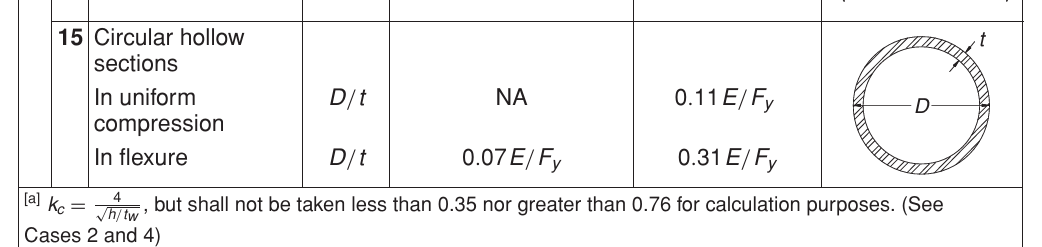

In [11]:
width_thickness_ratio = Od/t
Lamb_p = 0.07*(E/Fy)
Lamb_r = 0.31*(E/Fy)


print("W-T ratio:", width_thickness_ratio)
print("Lamda p",round(Lamb_p,2))
print("Lamda r",round(Lamb_r,2))
print(0.11*(E/Fy))

checkslender = width_thickness_ratio > Lamb_r 
if not checkslender:
    print("Section is NOT slender")

W-T ratio: 23.52
Lamda p 42.61
Lamda r 188.7
66.95652173913044
Section is NOT slender


the spreader bar is considered as an compact element so the local-buckling does not occur

## Euler critical buckling load

In [12]:
# Buckling load
P_critical = (math.pi ** 2 * E * I) / ((K * L) ** 2)
P_critical_tons = P_critical / 9.80665 / 1000  # N to metric tons
print(f"Euler Critical Buckling Load: {P_critical:.2f} N")
print(f"Euler Critical Buckling Load: {P_critical_tons:.2f} tons")

Euler Critical Buckling Load: 119404711.33 N
Euler Critical Buckling Load: 12175.89 tons


## ASME BTH-1 2017

In [13]:


Fa = ASME_BTH1_allowable_axial_compressive_stress(K, L, r, Fy, Nd, E)
Fa_MT = Fa / 10  # 1 MPa = 0.1 MT/m²
F = 37.43 * 1000 * 9.80665  # 75.01 T to N
F_app = F / A_s             # MPa
F_app_MT = F_app / 10       # MT/m²

print("\nCalculating compressive stress using design code ASME BTH-1 2017")
print("--" * 35)
print(f"Allowable Axial Compressive Stress: {Fa:.2f} MPa")
print(f"Allowable Axial Compressive Stress: {Fa_MT:.2f} MT/m²")

# Applied compressive force and stress
# print(F)
# print(A_s)
# print(F_app)

print(f"Applied Compressive Stress: {F_app:.2f} MPa")
print(f"Applied Compressive Stress: {F_app_MT:.2f} MT/m²")

# Check against allowable
if F_app_MT < Fa_MT:
    print("Applied compressive stress is within allowable limits.")
else:
    print("Applied compressive stress exceeds allowable limits!")


Slenderness: 27.704347542389176
C_c: 109.61373351564674
eq-3.3

Calculating compressive stress using design code ASME BTH-1 2017
----------------------------------------------------------------------
Allowable Axial Compressive Stress: 88.24 MPa
Allowable Axial Compressive Stress: 8.82 MT/m²
Applied Compressive Stress: 8.30 MPa
Applied Compressive Stress: 0.83 MT/m²
Applied compressive stress is within allowable limits.


# AISC 2005

In [14]:
Ag = (math.pi / 4) * (Od**2 - (Od - 2 * t)**2)
Pn, Fcr = AISC_allowable_compressive_force(K, L, r, Fy, E, Ag)

ASD_Pn = Pn / 1.67
LRFD_Pn = Pn * 0.9

print(f"Nominalaxialstrength: {Pn:.2f} N")
print(f"Criticalstress: {Fcr:.2f} MPa")
print(f"Design compressive strength (LRFD): {(LRFD_Pn / Ag):.2f} MPa")
print(f"Allowable compressive strength (ASD): {(ASD_Pn / Ag):.2f} MPa")


slenderness limit 116.20398107376228
E3-2
Nominalaxialstrength: 14460851.21 N
Criticalstress: 327.04 MPa
Design compressive strength (LRFD): 294.33 MPa
Allowable compressive strength (ASD): 195.83 MPa


With the applied compressive stress calculated as the previous section, we can see that it still below the critical stress calculated by the AISC 2005 code, so the spreader bar is safe under the compressive load. The Pipe is categorized as a symmetric and compact, the ratio $\frac{K \cdot L}{r} \le 4.71\sqrt\frac{E}{F_{y}}$ so that we can use the equation (E3-2)
$$
F_{cr} = \left[0.658^{\frac{F_{y}}{F_{e}}}\right] F_{y}
$$